# Template

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

np.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

In [6]:
scRNA_counts = pd.read_table(ag.data_dir / 'meritxell/counts_all_genes_2.tsv')
scRNA_means = pd.read_table(ag.data_dir / 'meritxell/means_all_genes_2.tsv')
scRNA_medians = pd.read_table(ag.data_dir / 'meritxell/medians_all_genes_2.tsv')
scRNA_std = pd.read_table(ag.data_dir / 'meritxell/standard_deviation_all_genes_2.tsv')

In [7]:
scRNA_means.loc[scRNA_means.sum(axis = 1) > 0].head()

,index,Early_spermatids:13,Early_spermatids:16,Early_spermatids:4,Endothelial:8,Late_spermatids:1,Late_spermatids:7,Leydig:0,Leydig:2,Macrophages:9,Meiosis:6,Myoid:11,Myoid:18,SSC:12,Sertoli:14,Sertoli:15,Spermatids:17,Spermatids:3,Spermatocytes:10,Spermatocytes:5
0,DDX11L1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000910,0.000000,0.0,0.001460,0.000000,0.002155,0.0,0.000000,0.001295,0.000000
1,RP11-34P13.3,0.000000,0.005115,0.000000,0.000000,0.00000,0.001883,0.0,0.000000,0.0,0.000910,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.008569
2,OR4G11P,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.001460,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,OR4F5,0.000000,0.002558,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.002920,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,RP11-34P13.7,0.019667,0.002558,0.000803,0.001222,0.00053,0.003766,0.0,0.001105,0.0,0.019108,0.001422,0.0,0.008759,0.001887,0.002155,0.0,0.006811,0.014249,0.005998


In [8]:
cell_types = ['SSC:12',
 'Meiosis:6',
 'Early_spermatids:13',
 'Early_spermatids:16',
 'Spermatids:17',
 'Late_spermatids:1',
 'Late_spermatids:7',
 'Spermatids:3',
 'Early_spermatids:4',
 'Spermatocytes:5',
 'Spermatocytes:10',
 'Leydig:0',
 'Leydig:2',
 'Endothelial:8',
 'Macrophages:9',
 'Sertoli:14',
 'Sertoli:15',
 'Myoid:11',
 'Myoid:18']

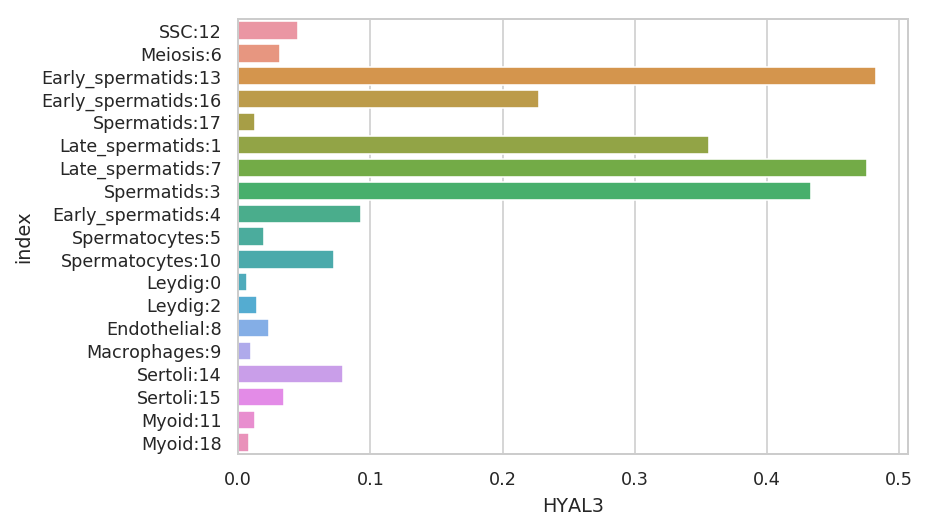

In [10]:
def plot_expression(gene):
    df = (scRNA_means
     .loc[lambda df: df['index'] == gene] 
     .set_index('index')
     .transpose()
     .reset_index()
     .assign(index=lambda df: pd.Categorical(df['index'], categories=cell_types, ordered=True))
    )
    sns.barplot(x=gene, y='index', data=df)

plot_expression("HYAL3")

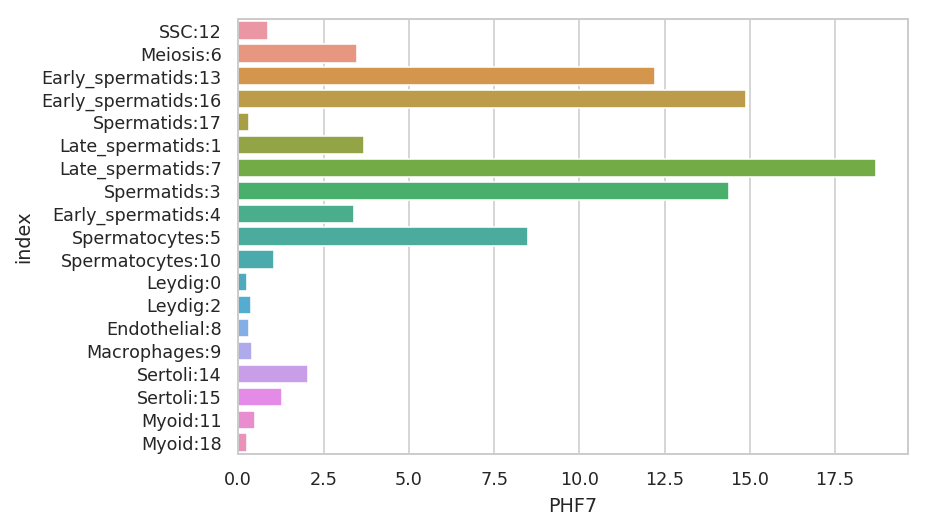

In [11]:
plot_expression("PHF7")

In [19]:
str(ag.data_dir / 'meritxell/umap_leiden_clusters.pdf')

'/home/kmt/simons/faststorage/people/kmt/data/meritxell/umap_leiden_clusters.pdf'

In [32]:
from IPython.display import Image, IFrame
from IPython.core.display import HTML
IFrame('../data/meritxell/umap_leiden_clusters.pdf', width=400, height=300)


## Genes with elevated expression in both placenta and testis

According to Human protein atlas

In [1]:
import mygene
from IPython.display import Markdown, display

from IPython.display import Image
from IPython.core.display import HTML 

mg = mygene.MyGeneInfo()

def gene_info(gene):
    top_hit = mg.query(gene, species='human', scopes='hgnc',
                       fields='symbol,alias,name,type_of_gene,summary,genomic_pos,genomic_pos_hg19')['hits'][0]

    tmpl = "**Symbol:** **_{symbol}_** "

    if 'type_of_gene' in top_hit:
        tmpl += "({type_of_gene})"
        
    if 'alias' in top_hit:
        if type(top_hit['alias']) is str:
            top_hit['aliases'] = top_hit['alias']
        else:
            top_hit['aliases'] = ', '.join(top_hit['alias'])
        tmpl += " &nbsp; &nbsp; &nbsp; &nbsp; **Aliases:** {aliases}"
    tmpl += '  \n'

    if 'name' in top_hit:
        tmpl += '*{name}*  \n'

    if 'summary' in top_hit:
        tmpl += "**Summary:** {summary}  \n"

    if 'genomic_pos' in top_hit and 'genomic_pos_hg19' in top_hit:
        if type(top_hit['genomic_pos']) is list:
            top_hit['hg38'] = ', '.join(['{chr}:{start}-{end}'.format(**d) for d in top_hit['genomic_pos']])
        else:
            top_hit['hg38'] = '{chr}:{start}-{end}'.format(**top_hit['genomic_pos'])
        if type(top_hit['genomic_pos_hg19']) is list:
            top_hit['hg19'] = ', '.join(['{chr}:{start}-{end}'.format(**d) for d in top_hit['genomic_pos_hg19']])
        else:
            top_hit['hg19'] = '{chr}:{start}-{end}'.format(**top_hit['genomic_pos_hg19'])            
        tmpl += "**Genomic position:** {hg38} (hg38), {hg19} (hg19)  \n"

    tmpl += "[Gene card](https://www.genecards.org/cgi-bin/carddisp.pl?gene={symbol})  \n".format(**top_hit)
    
    tmpl += "\n\n ----"
    
    display(Markdown(tmpl.format(**top_hit)))

In [2]:
genes = ['NAA11', 'CXorf67', 'RGPD1', 'TRIML2', 'TUBB1', 'MAGEA10', 'DPPA4', 
         'FAM184A', 'ATP1A4', 'CTAG2', 'IGDCC3', 'LHX8', 'HYAL4', 'ARMS2',
         'MKRN3', 'TCF15', 'IGF2BP1', 'L1TD1', 'TRIM58', 'DLX6', 'CTC-479C5.6', 
         'SH2D5', 'HBZ', 'MBNL3', 'TRIM60', 
         'CD300LG', 'ZIM2', 'DSCR4', 'PROK1', 'RGPD2', 'CLDN6', 'SH3TC2']

[gene_info(x) for x in genes]

ConnectionError: HTTPConnectionPool(host='mygene.info', port=80): Max retries exceeded with url: /v3/query?q=NAA11&species=human&fields=symbol%2Calias%2Cname%2Ctype_of_gene%2Csummary%2Cgenomic_pos%2Cgenomic_pos_hg19&scopes=hgnc (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x2b868a90e748>: Failed to establish a new connection: [Errno 111] Connection refused',))